In [1]:
from lbmpy.session import *
from lbmpy.phasefield.scenarios import create_three_phase_model
from pystencils.datahandling import SerialDataHandling
from lbmpy.phasefield.experiments1D import *

# 1D Numerical tests for 3-phase model


## 1) Interface validation (check for tanh shape)

This test ensures that an initialized sharp step function interface relaxes to the expected $\tanh$ form. 
Therefore a periodic 1D domain is set up. Due to the periodicity actually two interfaces have to be initialized.

In [2]:
alpha = 6
width = 100 * alpha
x_step1 = width // 4            # location of first interface
x_step2 = (width // 4) * 3      # location of second interface
include_rho = True

phaseIdx = 1 if include_rho else 0

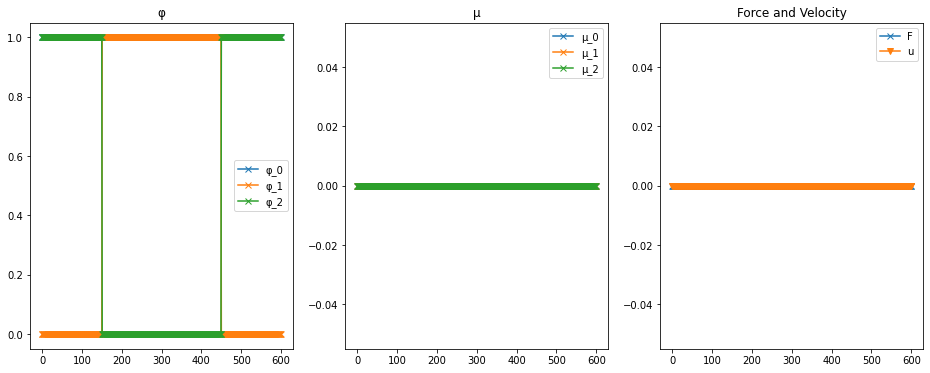

In [3]:
test_sc1 = create_three_phase_model(data_handling=SerialDataHandling((width, 1), periodicity=True),
                                    alpha=alpha,  # interface width
                                    kappa=(0.015/alpha, 0.015/alpha, 0.015/alpha),  # interface energy,  determines surface tension
                                    cahn_hilliard_relaxation_rates=1.0,  # relaxation rate = 1/tau, determines mobilities
                                    hydro_dynamic_relaxation_rate=1.0,  # relaxation rate = 1/tau, determines viscosity
                                    cahn_hilliard_gammas=[1, 1, 1/3],
                                    include_rho=include_rho,
                                    hydro_lbm_parameters={'force_model': 'guo'},
                                    )

vis_width = 25
init_sharp_interface(test_sc1, phase_idx=phaseIdx, inverse=False, x1=x_step1, x2=x_step2)
init_sharp_interface(test_sc1, phase_idx=phaseIdx + 1, inverse=True, x1=x_step1, x2=x_step2)
plot_status(test_sc1)

In the plot above, $(\phi_0, \phi_1, \phi_2) = (\rho, \phi, \psi)$. Similarly for the chemical potential.

Now we collect and visualize the profile of $φ_1$ over time

In [4]:
#test_sc1.run(10000)
#plot_status(test_sc1)

In [5]:
time_steps = [1, 100, 20_000, 30_000, 50_000, 100_000]
visSlice = make_slice[x_step1 - vis_width:x_step1 + vis_width, 0, phaseIdx]

phiProfiles = {}
maxVelocity = {}
avgVelocity = {}

for steps in time_steps:
    test_sc1.run(steps - test_sc1.time_steps_run)
    print(test_sc1.time_steps_run)
    phiProfiles[test_sc1.time_steps_run] = test_sc1.phi_slice(visSlice).copy()
    maxVelocity[test_sc1.time_steps_run] = np.max(test_sc1.velocity[:, 0, 0])
    avgVelocity[test_sc1.time_steps_run] = np.average(np.abs(test_sc1.velocity[:, 0, 0]))

1
100
20000
30000
50000
100000


Calculate values of analytic solution

In [6]:
from lbmpy.phasefield.analytical import analytic_interface_profile
x = np.arange(2 * vis_width) - vis_width
analytic = np.array([analytic_interface_profile(x_i-0.5, alpha) for x_i in x], dtype=np.float64)

and plot them together with the simulated profiles for different times. 
The deviation is measured as $avg(|\phi_{ref} - \phi_{analytic}|)$

Deviation at t=      1: 0.16254748219467502
Deviation at t=    100: 0.14368367993309497
Deviation at t=  20000: 0.09427408255754545
Deviation at t=  30000: 0.08618878111108655
Deviation at t=  50000: 0.07382637928562968
Deviation at t= 100000: 0.0550798375611979


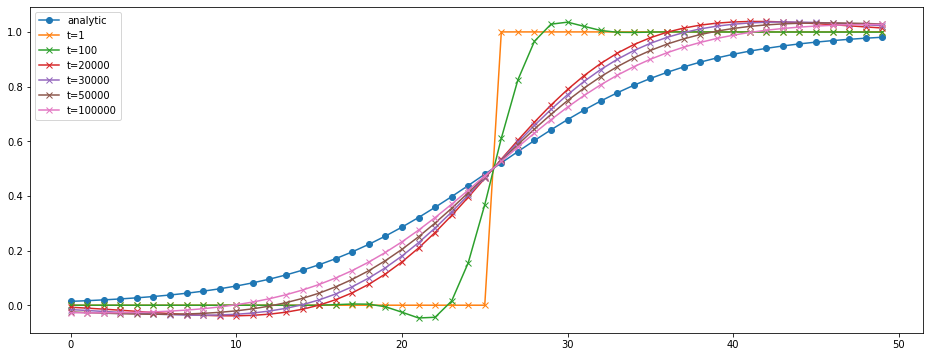

In [7]:
def deviation(profile):
    return np.average(np.abs(profile - analytic))


plt.plot(analytic, label='analytic', marker='o')
for t, profile in phiProfiles.items():
    plt.plot(profile, label="t=%d" % (t,), marker='x')
    print("Deviation at t={0:>7}: {1}".format(t, deviation(profile)))
plt.legend()

# assert against a measured threshold, to make sure code changes do not decrease accuracy
assert deviation(phiProfiles[time_steps[-1]]) < 0.06

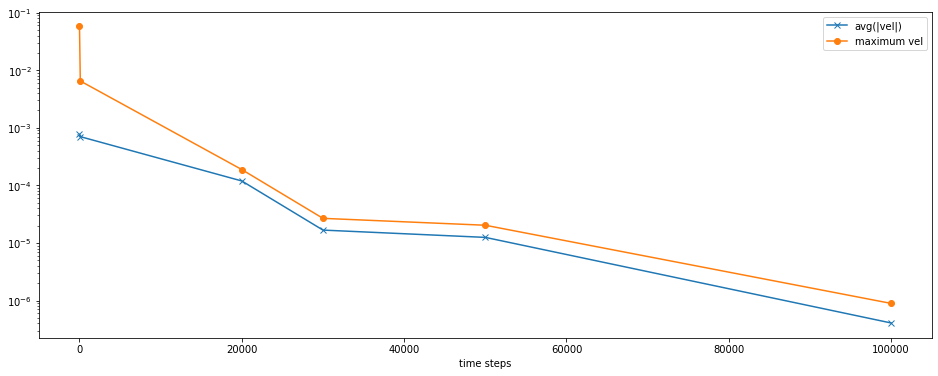

In [8]:
avg_vels = np.array([avgVelocity[t] for t in time_steps])
max_vels = np.array([maxVelocity[t] for t in time_steps])
plt.semilogy(time_steps, avg_vels, label='avg(|vel|)', marker='x')
plt.semilogy(time_steps, max_vels, label='maximum vel', marker='o')
plt.legend()
plt.xlabel("time steps")
assert maxVelocity[time_steps[-1]] < 1e-6

## 2) Advection of 1D interface

In this test, a constant velocity $u_x$ is initialized. Again, the scenario is fully periodic, so the interface should be advected with constant velocity and because of Galilean invariance the average velocity in the domain should remain constant.

In [9]:
test_sc2 = create_three_phase_model(data_handling=SerialDataHandling((width, 1), periodicity=True),
                                    alpha=1,  # interface width
                                    kappa=(0.015, 0.015, 0.015),  # interface energy,  determines surface tension
                                    cahn_hilliard_relaxation_rates=1.0,  # relaxation rate = 1/tau, determines mobilities
                                    hydro_dynamic_relaxation_rate=1.0,  # relaxation rate = 1/tau, determines viscosity
                                    include_rho=include_rho,
                                    solve_cahn_hilliard_with_finite_differences=False,
                                    hydro_lbm_parameters={'force_model': 'edm', 'compressible': True},
                                    dx=1,
                                    dt=1,  # only used if CahnHilliard is solved with finite differences
                                    )
ux = 0.05  # we choose a high velocity here, because then the error is visible faster, with u=0.001 the same
# momentum loss effect is visible, however after more time steps
init_sharp_interface(test_sc2, phase_idx=phaseIdx, inverse=False, x1=x_step1, x2=x_step2)
init_sharp_interface(test_sc2, phase_idx=phaseIdx + 1, inverse=True, x1=x_step1, x2=x_step2)

test_sc2.data_handling.fill(test_sc2.vel_field_name, ux, value_idx=0)
test_sc2.set_pdf_fields_from_macroscopic_values()

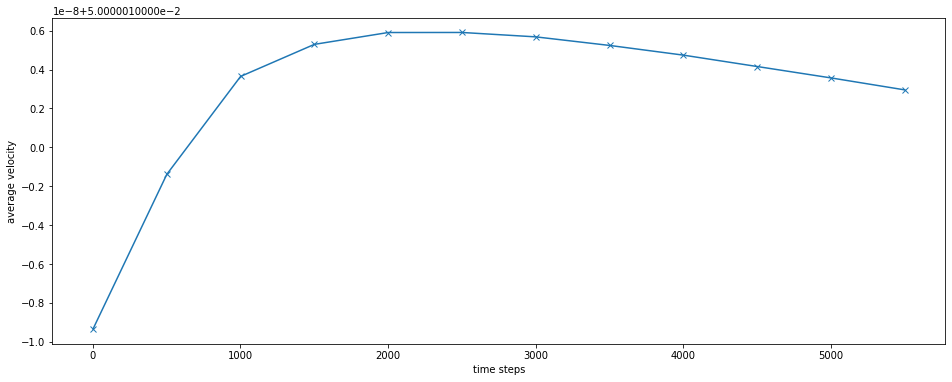

In [10]:
time_steps = 6_000
t = []
avg_velocity = []
test_sc2.run(1)
while test_sc2.time_steps_run < time_steps:
    avg_velocity.append(np.average(test_sc2.velocity[:, 0, 0]))
    t.append(test_sc2.time_steps_run)
    test_sc2.run(500)

plt.plot(t, avg_velocity, marker='x')
plt.xlabel("time steps")
plt.ylabel("average velocity");

In [11]:
assert (np.abs(np.array(avg_velocity)-ux) < 1e-7).all()

Further test: Disable hydrodynamic LBM i.e. velocity field is unchanged.


In [12]:
test_sc3 = create_three_phase_model(data_handling=SerialDataHandling((width, 1), periodicity=True),
                                    alpha=1,  # interface width
                                    kappa=(0.015, 0.015, 0.015),  # interface energy,  determines surface tension
                                    cahn_hilliard_relaxation_rates=1.0,  # relaxation rate = 1/tau, determines mobilities
                                    hydro_dynamic_relaxation_rate=1.0,  # relaxation rate = 1/tau, determines viscosity
                                    include_rho=include_rho,
                                    hydro_lbm_parameters={'force_model': 'edm', 'compressible': True},
                                    )
ux = 0.05

init_sharp_interface(test_sc3, phase_idx=phaseIdx, inverse=False, x1=x_step1, x2=x_step2)
init_sharp_interface(test_sc3, phase_idx=phaseIdx + 1, inverse=True, x1=x_step1, x2=x_step2)
test_sc3.data_handling.fill(test_sc3.vel_field_name, ux, value_idx=0)
test_sc3.set_pdf_fields_from_macroscopic_values()

test_sc3.run_hydro_lbm = False  # hydrodynamic LBM is disabled!

In [13]:
sums_over_force = []
while test_sc3.time_steps_run < 5_000:
    sums_over_force.append(np.sum(test_sc3.force[:, 0, 0]))
    test_sc3.run(100)

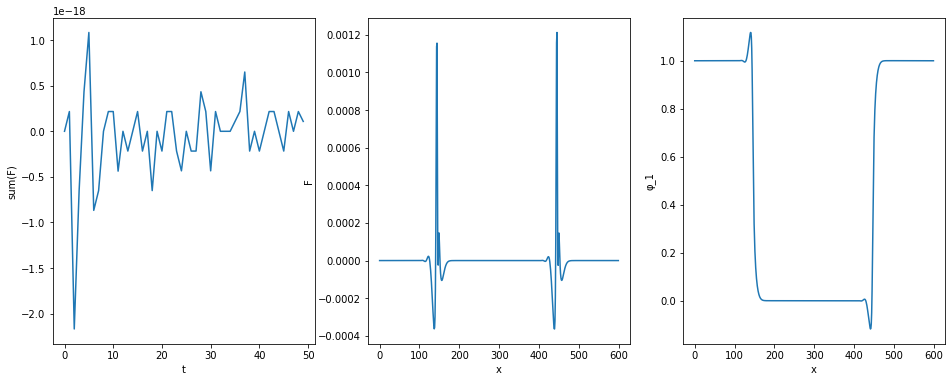

In [14]:
plt.subplot(1, 3, 1)

plt.plot(sums_over_force)
plt.xlabel("t")
plt.ylabel("sum(F)")

plt.subplot(1, 3, 2)
plt.plot(test_sc2.force[:, 0, 0])
plt.xlabel('x')
plt.ylabel('F')

plt.subplot(1, 3, 3)
plt.plot(test_sc2.phi[:, 0, 1]);
plt.xlabel('x')
plt.ylabel('φ_1');

In [15]:
assert (np.abs(sums_over_force) < 2e-16).all()